<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update7_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.4 MB 29.8 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [35]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '2y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
722,2022-01-08,41561.464844,42228.941406,40672.277344,41733.941406,28066355845,0,0
723,2022-01-09,41734.726562,42663.949219,41338.160156,41911.601562,21294384372,0,0
724,2022-01-10,41910.230469,42199.484375,39796.570312,41821.261719,32104232331,0,0
725,2022-01-11,41819.507812,43001.156250,41407.753906,42735.855469,26327648900,0,0
726,2022-01-12,42742.179688,44135.367188,42528.988281,43949.101562,33499938689,0,0
727,2022-01-13,43946.742188,44278.421875,42447.042969,42591.570312,47691135082,0,0
728,2022-01-14,42598.871094,43346.687500,41982.617188,43099.699219,23577403399,0,0
729,2022-01-15,43101.898438,43724.671875,42669.035156,43177.398438,18371348298,0,0
730,2022-01-16,43172.039062,43436.808594,42691.023438,43113.878906,17902097845,0,0
731,2022-01-17,43146.207031,43179.390625,41970.781250,42284.066406,20119615488,0,0


In [36]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.0,732.0
mean,30012.432175,30824.934652,29111.878294,30051.946465,4.018768e+10,0.0,0.0
std,19538.963698,20058.077371,18918.867121,19521.270808,2.060574e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,1.225260e+10,0.0,0.0
25%,9917.491699,10164.808105,9727.718994,9931.954102,2.776193e+10,0.0,0.0
50%,32212.335938,33309.777344,31065.469727,32237.828125,3.616346e+10,0.0,0.0
75%,47780.924805,49161.133789,46678.666992,47729.456055,4.756835e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [37]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [38]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [39]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [40]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [41]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [42]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [43]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
727,2022-01-13,42591.570312
728,2022-01-14,43099.699219
729,2022-01-15,43177.398438
730,2022-01-16,43113.878906
731,2022-01-17,42284.066406


## Creating Facebook Prophet Model

In [44]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [45]:
periods = 30
future=m.make_future_dataframe(periods)

In [46]:
forecast=m.predict(future)

In [47]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-17,6214.047271,6580.846335,12801.706238,6214.047271,6214.047271,3304.193312,3304.193312,3304.193312,3.779453,3.779453,3.779453,3300.413859,3300.413859,3300.413859,0.0,0.0,0.0,9518.240584
1,2020-01-18,6277.464364,5875.576965,12228.463874,6277.464364,6277.464364,2861.924861,2861.924861,2861.924861,39.658125,39.658125,39.658125,2822.266736,2822.266736,2822.266736,0.0,0.0,0.0,9139.389225
2,2020-01-19,6340.881456,5524.118842,11852.191602,6340.881456,6340.881456,2388.838284,2388.838284,2388.838284,30.010915,30.010915,30.010915,2358.827369,2358.827369,2358.827369,0.0,0.0,0.0,8729.719740
3,2020-01-20,6404.298548,5114.717389,11529.051701,6404.298548,6404.298548,1926.864047,1926.864047,1926.864047,9.547212,9.547212,9.547212,1917.316835,1917.316835,1917.316835,0.0,0.0,0.0,8331.162595
4,2020-01-21,6467.715641,4558.922195,11009.372390,6467.715641,6467.715641,1416.452373,1416.452373,1416.452373,-88.047473,-88.047473,-88.047473,1504.499847,1504.499847,1504.499847,0.0,0.0,0.0,7884.168014
5,2020-01-22,6531.132733,4422.785179,10796.922292,6531.132733,6531.132733,1178.372130,1178.372130,1178.372130,51.832289,51.832289,51.832289,1126.539841,1126.539841,1126.539841,0.0,0.0,0.0,7709.504863
6,2020-01-23,6594.549825,4382.187553,10423.495415,6594.549825,6594.549825,742.087306,742.087306,742.087306,-46.780520,-46.780520,-46.780520,788.867826,788.867826,788.867826,0.0,0.0,0.0,7336.637131
7,2020-01-24,6657.966917,3963.070606,10312.087059,6657.966917,6657.966917,499.847375,499.847375,499.847375,3.779453,3.779453,3.779453,496.067922,496.067922,496.067922,0.0,0.0,0.0,7157.814293
8,2020-01-25,6721.384010,4014.165002,10220.317408,6721.384010,6721.384010,291.440224,291.440224,291.440224,39.658125,39.658125,39.658125,251.782099,251.782099,251.782099,0.0,0.0,0.0,7012.824234
9,2020-01-26,6784.801102,3946.200091,10045.265069,6784.801102,6784.801102,88.647104,88.647104,88.647104,30.010915,30.010915,30.010915,58.636190,58.636190,58.636190,0.0,0.0,0.0,6873.448206


In [48]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

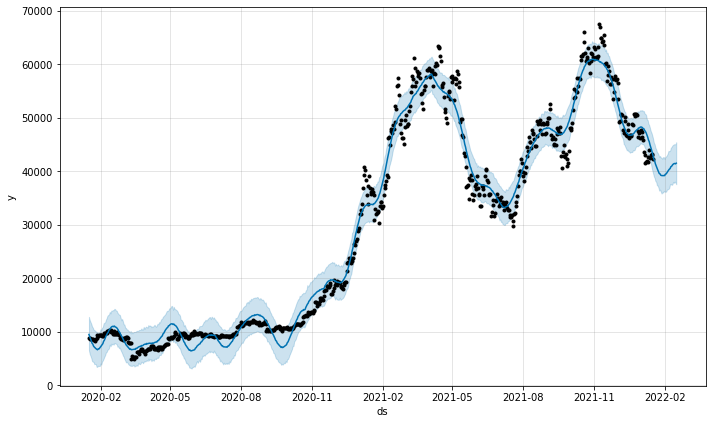

In [49]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

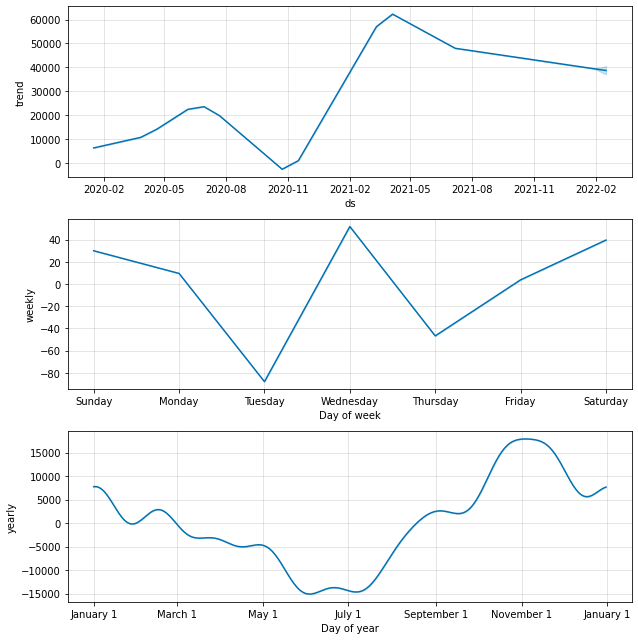

In [50]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>